<a href="https://colab.research.google.com/github/ImagingDataCommons/idc-radiomics-reproducibility/blob/main/notebooks/hosny_results_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook showcases the validation of the pipeline published in [Hosny et Al. - *Deep learning for lung cancer prognostication: A retrospective multi-cohort radiomics study*](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002711), reproduced with the tools provided by the Imaging Data Commons and the Google Cloud Platform.

The goal of this notebook is to provide the user with an example of how such tools can be used to run an AI/ML end-to-end analysis on cohorts hosted by the Imaging Data Commons portal, and to describe what we identified as the best practices to do so.


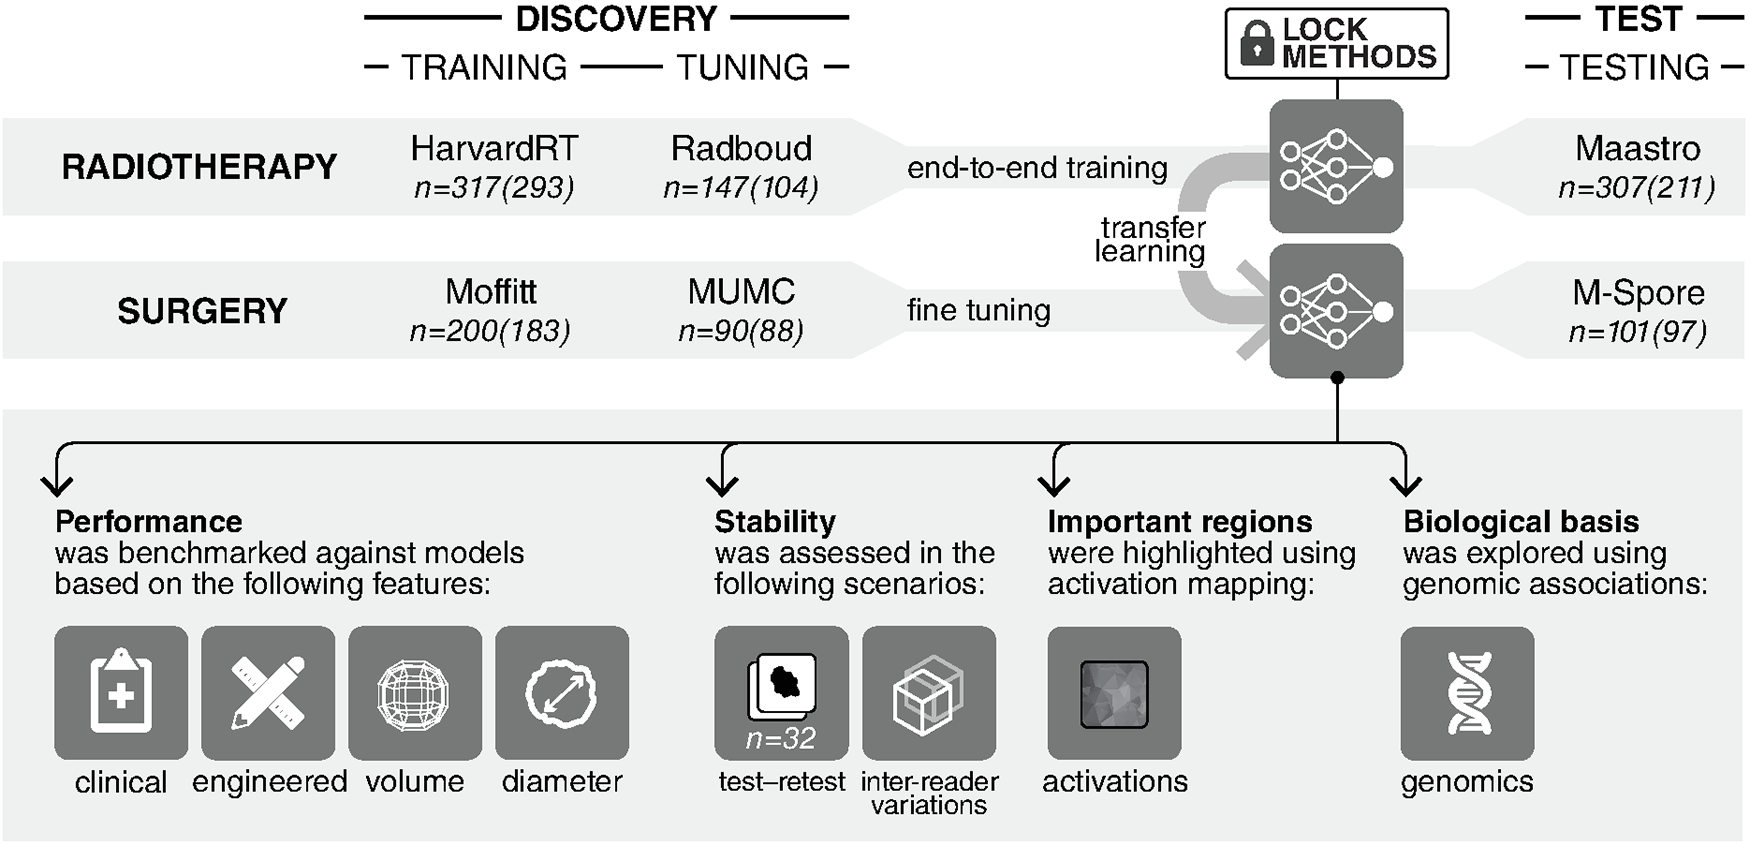

The notebook is part of the [IDC Radiomics Reproducibility](https://github.com/ImagingDataCommons/idc-radiomics-reproducibility) repository. If you use the code found in this notebook or you want to refer to some of our findings, please cite:

> Dennis Bontempi, Leonard Nuernberg, Deepa Krishnaswamy, Ahmed Hosny, Keyvan Farahani, Ron Kikinis, Andriy Fedorov, Hugo Aerts - _Transparent and Reproducible AI-based Medical Imaging Pipelines Using the Cloud_

As well as the original paper:

> Ahmed Hosny, Chintan Parmar, Thibaud P. Coroller, Patrick Grossmann, Roman Zeleznik, Avnish Kumar, Johan Bussink, Robert J. Gillies, Raymond H. Mak, Hugo JWL Aerts - _Deep learning for lung cancer prognostication: A retrospective multi-cohort radiomics study_


---

# Environment Setup

In [1]:
!git clone https://github.com/ImagingDataCommons/idc-radiomics-reproducibility.git idc-radiomics-reproducibility
!git clone https://github.com/yandexdataschool/roc_comparison.git roc_comparison

REPO_PATH="/content/idc-radiomics-reproducibility/src"
DATA_PATH="/content/idc-radiomics-reproducibility/data/hosny_et_al"

fatal: destination path 'idc-radiomics-reproducibility' already exists and is not an empty directory.
fatal: destination path 'roc_comparison' already exists and is not an empty directory.


In [2]:
%%capture
!pip install lifelines

In [3]:
import os
import sys
sys.path.append(REPO_PATH)

import numpy as np
import pandas as pd

from scipy import stats
from sklearn import metrics

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

from IPython.display import clear_output

# import for the DeLong test for correlated (paired) AUC curves
from math import exp
from roc_comparison.compare_auc_delong_xu import delong_roc_test

# ----------------------------------------

#everything that has to do with plotting goes here below

import matplotlib
matplotlib.use('agg')

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'png'

plt.rcParams['figure.dpi'] = 300

## ----------------------------------------

import seaborn as sns

In [4]:
# analysis baseline: Hosny et al. results
baseline_csv_name = 'nsclc-radiomics_hosny_baseline.csv'
baseline_csv_path = os.path.join(DATA_PATH, baseline_csv_name)
baseline_df = pd.read_csv(baseline_csv_path)

# list of the NSCLC-Radiomics subjects analysed in Hosny et al.
baseline_subj_list = sorted([a for a in list(baseline_df["id"].dropna())])

In [5]:
baseline_subj_list[:5]

['LUNG1-002', 'LUNG1-003', 'LUNG1-004', 'LUNG1-005', 'LUNG1-006']

In [6]:
display(baseline_df.info())
display(baseline_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Columns: 1017 entries, id to squareroot_glszm_SizeZoneNonUniformityNormalized
dtypes: float64(1008), int64(1), object(8)
memory usage: 1.6+ MB


None

,id,surv2yr,logit_0,logit_1,general_info_BoundingBox,general_info_GeneralSettings,general_info_ImageHash,general_info_ImageSpacing,general_info_InputImages,general_info_MaskHash,...,squareroot_glrlm_LongRunHighGrayLevelEmphasis,squareroot_glrlm_RunPercentage,squareroot_glrlm_LongRunLowGrayLevelEmphasis,squareroot_glrlm_RunEntropy,squareroot_glrlm_HighGrayLevelRunEmphasis,squareroot_glrlm_RunLengthNonUniformityNormalized,squareroot_glszm_GrayLevelVariance,squareroot_glszm_SmallAreaHighGrayLevelEmphasis,squareroot_glszm_GrayLevelNonUniformityNormalized,squareroot_glszm_SizeZoneNonUniformityNormalized
0,LUNG1-002,0,0.968347,0.031653,"(6, 6, 5, 32, 32, 26)","{'distances': [1], 'additionalInfo': True, 'en...",a577b1b7d4375b9033fdda06aedf5d57a357725d,"(0.9770000000000001, 0.9770000000000001, 1.0)","{'Logarithm': {}, 'Square': {}, 'LoG': {}, 'Ex...",acbeafb30d4025a34a9440ab239954e10ed7ecd0,...,3125.021178,0.897218,0.004137,5.371893,2156.126099,0.820418,275.485496,1206.671878,0.021989,0.567945
1,LUNG1-003,0,0.958545,0.041455,"(6, 5, 6, 14, 21, 16)","{'distances': [1], 'additionalInfo': True, 'en...",80c517262c15e91714d2b68bc382183c5b37f2eb,"(0.9770000000000001, 0.9770000000000001, 1.0)","{'Logarithm': {}, 'Square': {}, 'LoG': {}, 'Ex...",3b77f3b3276adbf3ef9a2349570a69963bad2904,...,2917.664614,0.911738,0.018233,5.630110,2060.416208,0.857786,434.694760,767.679911,0.026017,0.326410
2,LUNG1-004,0,0.966061,0.033939,"(5, 5, 6, 17, 23, 35)","{'distances': [1], 'additionalInfo': True, 'en...",e20a402cf62f481dc190b62e20f6d514805b904c,"(0.9765624999999998, 0.9765624999999998, 2.999...","{'Logarithm': {}, 'Square': {}, 'LoG': {}, 'Ex...",3eb541b1683488a784e3287b9cb35b5609e06456,...,1565.688979,0.944076,0.002404,5.211423,1275.933449,0.897489,108.771689,811.938282,0.030057,0.529306
3,LUNG1-005,0,0.922006,0.077994,"(6, 6, 5, 17, 26, 23)","{'distances': [1], 'additionalInfo': True, 'en...",3fa57bbe79c711b41029f73373478f3fb844f117,"(0.9770000000000001, 0.9770000000000001, 1.0)","{'Logarithm': {}, 'Square': {}, 'LoG': {}, 'Ex...",5b79d37b692d00b039ba447d5ac7ba38ff2cebf4,...,4162.812549,0.937182,0.001449,5.300661,3345.457240,0.884061,286.408921,2070.346753,0.026143,0.560653
4,LUNG1-006,0,0.898475,0.101525,"(6, 6, 5, 21, 22, 23)","{'distances': [1], 'additionalInfo': True, 'en...",9ed1f78f9ae3ae61b0b983eb1dce4982e2b645a2,"(0.9770000000000001, 0.9770000000000001, 1.0)","{'Logarithm': {}, 'Square': {}, 'LoG': {}, 'Ex...",51f63a6a38c2fbf51f6d7b87b9421cc93752573d,...,1997.930692,0.932777,0.013044,5.704314,1501.008054,0.878849,290.847603,659.287678,0.021000,0.410438


---

In [7]:
# analysis baseline: Hosny et al. results
replicated_csv_name = 'nsclc-radiomics_reproducibility.csv'
replicated_csv_path = os.path.join(DATA_PATH, replicated_csv_name)
replicated_df = pd.read_csv(replicated_csv_path)

# list of the NSCLC-Radiomics subjects analysed in Hosny et al.
replicated_subj_list = sorted([a for a in list(replicated_df["PatientID"].dropna())])

In [8]:
replicated_subj_list[:5]

['LUNG1-002', 'LUNG1-003', 'LUNG1-004', 'LUNG1-005', 'LUNG1-006']

In [9]:
display(replicated_df.info())
display(replicated_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               206 non-null    object 
 1   CNN_output_argmax       206 non-null    int64  
 2   CNN_logit0              206 non-null    float64
 3   baseline_logit0         206 non-null    float64
 4   baseline_output_argmax  206 non-null    int64  
 5   surv2yr                 206 non-null    int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 9.8+ KB


None

,PatientID,CNN_output_argmax,CNN_logit0,baseline_logit0,baseline_output_argmax,surv2yr
0,LUNG1-226,0,0.965940,0.966019,0,0
1,LUNG1-196,0,0.967094,0.968133,0,0
2,LUNG1-007,0,0.951402,0.951439,0,0
3,LUNG1-053,0,0.978494,0.975959,0,0
4,LUNG1-329,0,0.952828,0.954214,0,0


# Clinical Data

Note: the clinical data can also be parsed from IDC directly.

For the complete tutorial on this topic, please see [this notebook](https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/clinical_data_intro.ipynb).

In [10]:
# analysis baseline: Hosny et al. results
clinical_csv_name = 'nsclc-radiomics_clinical.csv'
clinical_csv_path = os.path.join(DATA_PATH, clinical_csv_name)
clinical_df = pd.read_csv(clinical_csv_path)

# list of the NSCLC-Radiomics subjects analysed in Hosny et al.
clinical_subj_list = sorted([a for a in list(clinical_df["PatientID"].dropna())])

In [11]:
clinical_subj_list[:5]

['LUNG1-001', 'LUNG1-002', 'LUNG1-003', 'LUNG1-004', 'LUNG1-005']

In [12]:
display(clinical_df.info())
display(clinical_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PatientID         422 non-null    object 
 1   age               400 non-null    float64
 2   clinical.T.Stage  421 non-null    float64
 3   Clinical.N.Stage  422 non-null    int64  
 4   Clinical.M.Stage  422 non-null    int64  
 5   Overall.Stage     421 non-null    object 
 6   Histology         380 non-null    object 
 7   gender            422 non-null    object 
 8   Survival.time     422 non-null    int64  
 9   deadstatus.event  422 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 33.1+ KB


None

,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
0,LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1
1,LUNG1-002,83.8001,2.0,0,0,I,squamous cell carcinoma,male,155,1
2,LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1
3,LUNG1-004,70.8802,2.0,1,0,II,squamous cell carcinoma,male,141,1
4,LUNG1-005,80.4819,4.0,2,0,IIIb,squamous cell carcinoma,male,353,1


Join the clinical data DataFrame with the one from the previous notebook (replicated analysis).

In [13]:
results_df = replicated_df.merge(clinical_df, on="PatientID")

Prepare the dataset for analysis. In this case, we split in two groups based on the median of the risk score computed on the Radboud dataset (as described in Figure 3 of the paper).

The tables storing the results from Hosny et al. pipeline are available at the model's repository: https://github.com/modelhub-ai/deep-prognosis

In [14]:
# analysis baseline: Hosny et al. results
radboud_csv_name = 'Radboud.csv'
radboud_csv_path = os.path.join(DATA_PATH, radboud_csv_name)
radboud_df = pd.read_csv(radboud_csv_path)

median_threshold = np.median(radboud_df["logit_0"].values)
print("Median risk score (tuning set):", median_threshold)

Median risk score (tuning set): 0.9721243980000001


In [15]:
display(radboud_df.info())
display(radboud_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Columns: 1017 entries, id to squareroot_glszm_SizeZoneNonUniformityNormalized
dtypes: float64(1003), int64(7), object(7)
memory usage: 826.4+ KB


None

,id,surv2yr,logit_0,logit_1,general_info_BoundingBox,general_info_GeneralSettings,general_info_ImageHash,general_info_ImageSpacing,general_info_InputImages,general_info_MaskHash,...,squareroot_glrlm_LongRunHighGrayLevelEmphasis,squareroot_glrlm_RunPercentage,squareroot_glrlm_LongRunLowGrayLevelEmphasis,squareroot_glrlm_RunEntropy,squareroot_glrlm_HighGrayLevelRunEmphasis,squareroot_glrlm_RunLengthNonUniformityNormalized,squareroot_glszm_GrayLevelVariance,squareroot_glszm_SmallAreaHighGrayLevelEmphasis,squareroot_glszm_GrayLevelNonUniformityNormalized,squareroot_glszm_SizeZoneNonUniformityNormalized
0,1,1,0.972305,0.027695,"(6, 6, 6, 22, 34, 44)","{'distances': [1], 'additionalInfo': True, 'en...",64f8af1b632c3e70e1a18c6cea4511460c144f7a,"(0.9375000000000002, 0.9375000000000002, 3.000...","{'Logarithm': {}, 'Square': {}, 'LoG': {}, 'Ex...",8aa0aeaa92796c9ff22fa5ea1bc6b61eed95ec87,...,2323.752800,0.940274,0.004625,6.103566,1910.133777,0.890533,336.867711,1377.036254,0.017220,0.547338
1,2,0,0.971212,0.028788,"(5, 6, 6, 19, 17, 22)","{'distances': [1], 'additionalInfo': True, 'en...",0eefbff6e59086d08d2e33645cce7176796415b2,"(0.938, 0.938, 3.0000000000000004)","{'Logarithm': {}, 'Square': {}, 'LoG': {}, 'Ex...",98ac405e25e4aa5bffbaaac7dbb3353e7e85ca3c,...,3742.924076,0.920038,0.001426,5.129774,2835.656431,0.857379,227.132898,1788.648910,0.032198,0.552180
2,3,0,0.981770,0.018230,"(5, 6, 6, 28, 20, 38)","{'distances': [1], 'additionalInfo': True, 'en...",8b4fa36459848ff1de375603318847faea538ce3,"(1.171875, 1.171875, 3.0000000000000004)","{'Logarithm': {}, 'Square': {}, 'LoG': {}, 'Ex...",5a806e226d20f6ed5026a921759962416a310638,...,3191.134744,0.906179,0.001969,4.950641,2258.532856,0.836061,119.286715,1366.679626,0.037030,0.526933
3,4,1,0.968498,0.031502,"(5, 5, 6, 16, 40, 28)","{'distances': [1], 'additionalInfo': True, 'en...",c2c5bcf455d4938749a88052b5721535cd2e4ff9,"(0.938, 0.938, 3.0000000000000004)","{'Logarithm': {}, 'Square': {}, 'LoG': {}, 'Ex...",759d6c7528f5658d902725ca9170c23f5b6c262b,...,1265.503811,0.941865,0.005972,5.577417,1001.534604,0.894120,131.002331,612.175538,0.025303,0.510327
4,5,0,0.966816,0.033184,"(5, 6, 6, 27, 21, 24)","{'distances': [1], 'additionalInfo': True, 'en...",a11ed8a281575513699093b01a381fb89f32601b,"(0.9765624999999998, 0.9765624999999998, 2.999...","{'Logarithm': {}, 'Square': {}, 'LoG': {}, 'Ex...",0fb636fa1179d9a828eb554ff596f443d581cf83,...,2802.467279,0.946026,0.003685,5.751348,2282.561603,0.899590,299.243538,1394.740730,0.019646,0.571747


In [16]:
results_df["group_baseline"]="Low Risk"
results_df["group_baseline_cat"]=0

results_df["group_replicated"]="Low Risk"
results_df["group_replicated_cat"]=0

results_df.loc[results_df['baseline_logit0']>median_threshold, 'group_baseline']="High Risk"
results_df.loc[results_df['baseline_logit0']>median_threshold, 'group_baseline_cat']=1

results_df.loc[results_df['CNN_logit0']>median_threshold, 'group_replicated']="High Risk"
results_df.loc[results_df['CNN_logit0']>median_threshold, 'group_replicated_cat']=1

In [17]:
# 5-years follow-up - closer to the original analisys (results are almost identical)
results_df["Survival.time_5y"] = results_df["Survival.time"]
results_df["deadstatus.event_5y"] = results_df["deadstatus.event"]

# if the patient died AFTER five years, set the "deadstatus.event" variable AT 5 years to 0
results_df.loc[(results_df['Survival.time']>365.25*5) & \
               (results_df['deadstatus.event']==1), 'deadstatus.event_5y']=0

# cap "Survival.time_5y" to five years when it exceeds five years
results_df.loc[results_df['Survival.time']>365.25*5,  'Survival.time_5y']=np.floor(365.25*5).astype(int)

---

# AUROC Analisys (2 years survival)

In [18]:
sns.set_style("ticks")
sns.set_context(rc={"grid.linewidth": .5})

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [19]:
def style_axis_auc(ax):

  ax.set_xlim([0, 1])
  ax.set_ylim([0, 1])
  ax.set_xlabel('FPR')
  ax.set_ylabel('TPR')
  ax.grid(linewidth = .25)
  ax.plot([0, 1], [0, 1], 'k--', linewidth=.75)

  ax.tick_params(width = .75)
  for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(.75)

  sns.despine()

  return ax

In [20]:
y_true = np.stack(results_df["surv2yr"].values)
y_pred_baseline = 1 - np.stack(results_df["baseline_logit0"].values)
y_pred_replication = 1 - np.stack(results_df["CNN_logit0"].values)

baseline = dict()
replication = dict()


baseline["fpr"], baseline["tpr"], baseline["thr_roc"] = metrics.roc_curve(y_true, y_pred_baseline)
baseline["prc"], baseline["rec"], baseline["thr_pr"] = metrics.precision_recall_curve(y_true, y_pred_baseline)

replication["fpr"], replication["tpr"], replication["thr_roc"] = metrics.roc_curve(y_true, y_pred_replication)
replication["prc"], replication["rec"], replication["thr_pr"] = metrics.precision_recall_curve(y_true, y_pred_replication)


baseline["roc_auc"] = metrics.auc(baseline["fpr"], baseline["tpr"])
baseline["pr_auc"] = metrics.auc(baseline["rec"], baseline["prc"])

replication["roc_auc"] = metrics.auc(replication["fpr"], replication["tpr"])
replication["pr_auc"] = metrics.auc(replication["rec"], replication["prc"])

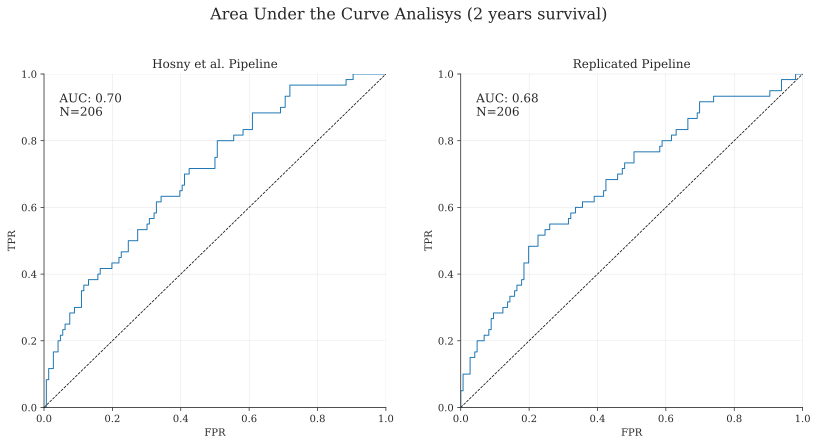

In [21]:
fig, (ax_b, ax_r) = plt.subplots(1, 2, figsize = (12, 6.75))

ax_b.plot(
    baseline["fpr"],
    baseline["tpr"],
    label = 'ROC AUC: %2.2f'%(baseline["roc_auc"]),
    lw = 1,
    )

ax_b = style_axis_auc(ax_b)
ax_b.set_title('Hosny et al. Pipeline')
ax_b.text(
    x=0.045, y=0.875,
    s='AUC: %2.2f\nN=%g'%(baseline["roc_auc"], len(results_df)),
    fontsize=12,
    )

sns.despine()

## ----------------------------------------

ax_r.plot(
    replication["fpr"],
    replication["tpr"],
    label = 'ROC AUC: %2.2f'%(replication["roc_auc"]),
    lw = 1,
    )

ax_r = style_axis_auc(ax_r)
ax_r.set_title('Replicated Pipeline')
ax_r.text(
    x=0.045, y=0.875,
    s='AUC: %2.2f\nN=%g'%(replication["roc_auc"], len(results_df)),
    fontsize=12,
    )

fig.suptitle("Area Under the Curve Analisys (2 years survival)", size=16, y=0.95)
fig.tight_layout(pad=3.0)
sns.despine()

As the difference in ROC AUC is very little, we can use a set of statistical tools to assess whether the difference in the distributions of the two models output is significant.

A good starting point is the Mann-Whitney U test. The Mann-Whitney U test is a non-parametric test used to compare two groups of continuous variables that, in simple terms, checks whether one set of predictions tends to have higher values than (and thus differ from) the other. In our case, we can use the Mann-Whitney U test to assess whether there is a statistically significant difference in the scores resulting from the original pipeline and the replicated one.

We can first visualize how the predictions from the two pipeline (i.e., the one from Hosny et al. and our replication) are distributed:

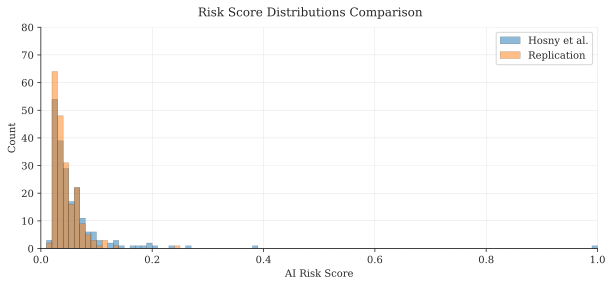

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

ax.hist(y_pred_baseline, bins=np.linspace(0, 1, 101),
        alpha=0.5, edgecolor='black', linewidth=.25)
ax.hist(y_pred_replication, bins=np.linspace(0, 1, 101),
        alpha=0.5, edgecolor='black', linewidth=.25)

ax.set_xlim([0, 1.0])
ax.set_ylim([0, 80])

ax.grid(linewidth = .25)

ax.set_xlabel('AI Risk Score')
ax.set_ylabel('Count')

ax.legend(labels=['Hosny et al.', 'Replication'], loc='upper right')

fig.suptitle("Risk Score Distributions Comparison", size=12, y=0.95)

sns.despine()

We can then compute the Mann-Whitney U test.

The null hypothesis is that the distribution of the two scores is the same. If the p-value we get from this test is below the threshold of significance, then we can reject the null hypothesis.

In [23]:
mwustat, pval = stats.mannwhitneyu(y_pred_baseline, y_pred_replication)

print(mwustat)
print(pval)

23472.0
0.06222529233777433


Since `p > 0.05`, we cannot reject the null hypothesis - and thus, we cannot conclude the difference in results of the two pipelines is significant.

---

Another way to assess the significance of the difference between the two ROC is the DeLong test for correlated (paired) AUC curves [in its fast implementation by X. Sun and W. Xu](https://ieeexplore.ieee.org/document/6851192).

The DeLong test for paired AUC curves computes the log(p-value) for the alternative hypothesis that two ROC AUCs are different.

In [24]:
# Computes log(p-value) for hypothesis that two ROC AUCs are different
delong_log_pval = delong_roc_test(y_true, y_pred_baseline, y_pred_replication)
delong_pval = exp(delong_log_pval)

print(delong_pval)

0.6802650987584817


Since the p-value computed is `p > 0.05`, we cannot reject the null hypothesis - and thus, we cannot conclude the difference in the AUCs is significant.

# AUPRC Analisys (2 years survival)

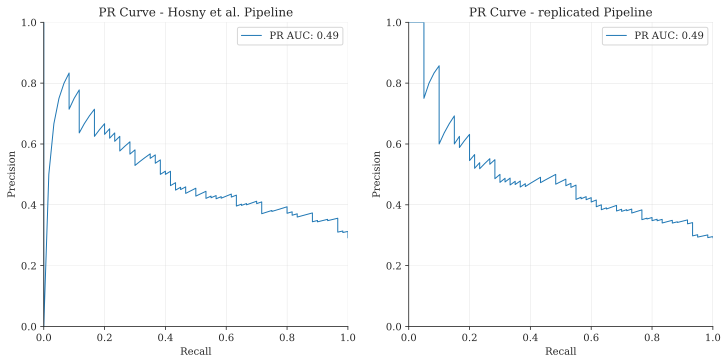

In [25]:
fig, (ax_b, ax_r) = plt.subplots(1, 2, figsize = (12, 12))

# plot PR curve
ax_b.plot(
    baseline["rec"],
    baseline["prc"],
    label = 'PR AUC: %2.2f'%(baseline["pr_auc"]),
    lw = 1,
    )

# plot operating point on PR curve
ax_b.legend(loc = 'upper right')
ax_b.set_aspect('equal', 'box')
ax_b.set_xlim([0, 1])
ax_b.set_ylim([0, 1])
ax_b.set_xlabel('Recall')
ax_b.set_ylabel('Precision')
ax_b.set_title('PR Curve - Hosny et al. Pipeline')
ax_b.grid(linewidth = .25)

sns.despine()

## ----------------------------------------

# plot PR curve
ax_r.plot(
    replication["rec"],
    replication["prc"],
    label = 'PR AUC: %2.2f'%(replication["pr_auc"]),
    lw = 1,
    )

# plot operating point on PR curve
ax_r.legend(loc = 'upper right')
ax_r.set_aspect('equal', 'box')
ax_r.set_xlim([0, 1])
ax_r.set_ylim([0, 1])
ax_r.set_xlabel('Recall')
ax_r.set_ylabel('Precision')
ax_r.set_title('PR Curve - replicated Pipeline')
ax_r.grid(linewidth = .25)

sns.despine()

# Survival Analysis

In [26]:
results_df_baseline = results_df[["group_baseline_cat", "Survival.time", "deadstatus.event"]]

cph_baseline = CoxPHFitter()
cph_baseline.fit(
    results_df_baseline,
    duration_col='Survival.time',
    event_col='deadstatus.event'
    )

# 5-years follow-up - closer to the original analisys (results are almost identical)
"""
results_df_baseline = results_df[["group_baseline_cat", "Survival.time_5y", "deadstatus.event_5y"]]

cph_baseline = CoxPHFitter()
cph_baseline.fit(
    results_df_baseline,
    duration_col='Survival.time_5y',
    event_col='deadstatus.event_5y'
    )
"""

p_val_baseline=cph_baseline.summary["p"].values
cph_baseline.print_summary()
#cph.plot()

<lifelines.CoxPHFitter: fitted with 206 total observations, 16 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 206
number of events observed = 190
   partial log-likelihood = -852.58
         time fit was run = 2023-11-03 16:23:26 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
group_baseline_cat   0.56       1.75       0.17             0.23             0.89                 1.26                 2.44

                     cmp to    z      p   -log2(p)
covariate                                         
group_baseline_cat     0.00 3.30 <0.005      10.04
---
Concordance = 0.56
Partial AIC = 1707.16
log-likelihood ratio test = 9.94 on 1 df
-log2(p) of ll-ratio test = 9.27

In [27]:
results_df_replicated = results_df[["group_replicated_cat", "Survival.time", "deadstatus.event"]]

cph_replicated = CoxPHFitter()
cph_replicated.fit(
    results_df_replicated,
    duration_col='Survival.time',
    event_col='deadstatus.event'
    )

# 5-years follow-up - closer to the original analisys (results are almost identical)
"""
results_df_replicated = results_df[["group_replicated_cat", "Survival.time_5y", "deadstatus.event_5y"]]

cph_replicated = CoxPHFitter()
cph_replicated.fit(
    results_df_replicated,
    duration_col='Survival.time_5y',
    event_col='deadstatus.event_5y'
    )
"""

p_val_replicated=cph_replicated.summary["p"].values
cph_replicated.print_summary()
#cph.plot()

<lifelines.CoxPHFitter: fitted with 206 total observations, 16 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 206
number of events observed = 190
   partial log-likelihood = -855.11
         time fit was run = 2023-11-03 16:23:26 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
group_replicated_cat   0.37       1.45       0.16             0.05             0.69                 1.05                 2.00

                       cmp to    z    p   -log2(p)
covariate                                         
group_replicated_cat     0.00 2.27 0.02       5.44
---
Concordance = 0.54
Partial AIC = 1712.23
log-likelihood ratio test = 4.87 on 1 df
-log2(p) of ll-ratio test = 5.20

---

# Kaplan-Meier Analysis

In [28]:
sns.set_style("ticks")
sns.set_context(rc={"grid.linewidth": .5})

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [29]:
def style_axis_km(ax):
  ax.set_ylabel("Survival Probability")
  ax.set_xlabel("Time [years]")
  ax.set_ylim([0, 1])
  ax.set_xlim([0, 365.25*5])

  xticks = [365.25*a for a in range(0, 6)]
  xticks_labels = [a for a in range(0, 6)]
  ax.set_xticks(xticks, xticks_labels)
  ax.legend(framealpha=0)
  ax.tick_params(width = .75)

  for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(.75)

  ax.grid(linewidth = .25)
  sns.despine()
  return ax

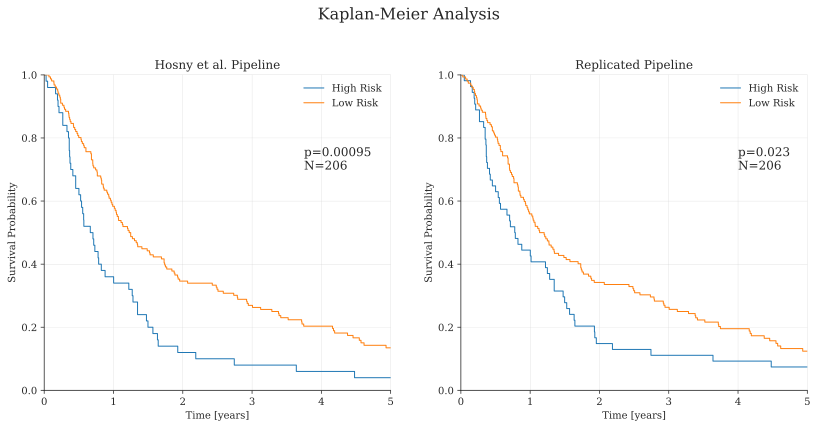

In [30]:
fig, (ax_b, ax_r) = plt.subplots(1, 2, figsize = (12, 6.5))

kmf = KaplanMeierFitter()

for name, grouped_df in results_df.groupby('group_baseline'):
    kmf.fit(
        grouped_df["Survival.time"],
        grouped_df["deadstatus.event"],
        label=name)

    kmf.plot_survival_function(
        ax=ax_b,
        lw=1,
        ci_alpha=0.0,
        )

ax_b = style_axis_km(ax_b)

ax_b.set_title("Hosny et al. Pipeline")
ax_b.text(
    x=365.25*3.75, y=0.7,
    s='p=%2.5f\nN=%g'%(
        p_val_baseline,
        len(results_df)
        ),
    fontsize=12,
    )

# --------------------

kmf = KaplanMeierFitter()

for name, grouped_df in results_df.groupby('group_replicated'):
    kmf.fit(
        grouped_df["Survival.time"],
        grouped_df["deadstatus.event"],
        label=name,
        alpha = 0.1)

    kmf.plot_survival_function(
        ax=ax_r,
        lw=1,
        ci_alpha=0.0,
        )

ax_r.set_title("Replicated Pipeline")
ax_r = style_axis_km(ax_r)

ax_r.text(
    x=365.25*4, y=0.7,
    s='p=%2.3f\nN=%g'%(
        p_val_replicated,
        len(results_df)
        ),
    fontsize=12,
    )

fig.suptitle("Kaplan-Meier Analysis", size=16, y=0.95)
fig.tight_layout(pad=3.0)
sns.despine()

# Extending the Study

Finally, we can run the analysis pipeline on the subset of patients that was excluded from the original publication due to missing clinical and or imaging data in a previous iteration of the dataset, testing the pipeline on the whole NSCLC-Radiomics dataset (after excluding one patient without a tumour segmentation mask - as documented on the dataset page).

In [31]:
# study extension: running Hosny et al. results
extension_csv_name = 'nsclc-radiomics_reproducibility_whole.csv'
extension_csv_path = os.path.join(DATA_PATH, extension_csv_name)
extension_df = pd.read_csv(extension_csv_path)
extension_df = extension_df.merge(clinical_df, on="PatientID")

In [32]:
# create a column for 2 years survival based on the clinical data and not on the previous analysis by Hosny et Al.
extension_df["surv2yr_updated"] = 0

# function to apply to each row
def check_survival(row):
    # if the patient survived longer than 2 years
    if row['Survival.time'] > 365*2:
        return 1
    # if the patient died before the 2 years
    elif row['deadstatus.event'] == 1 and row['Survival.time'] <= 730:
        return 0
    # if the patient was lost to follow-up (but survived; i.e., censored)
    else:
        return 1

# Apply the function to each row
extension_df['surv2yr_updated'] = extension_df.apply(check_survival, axis=1)

In [33]:
y_true = np.stack(extension_df["surv2yr_updated"].values)
y_pred_extension = 1 - np.stack(extension_df["CNN_logit0"].values)

extension = dict()

extension["fpr"], extension["tpr"], extension["thr_roc"] = metrics.roc_curve(y_true, y_pred_extension)
extension["prc"], extension["rec"], extension["thr_pr"] = metrics.precision_recall_curve(y_true, y_pred_extension)

extension["roc_auc"] = metrics.auc(extension["fpr"], extension["tpr"])
extension["pr_auc"] = metrics.auc(extension["rec"], extension["prc"])

We can compare the distribution of the scores between the replication cohort and the rest of NSCLC-Radiomics cohort by running the following:

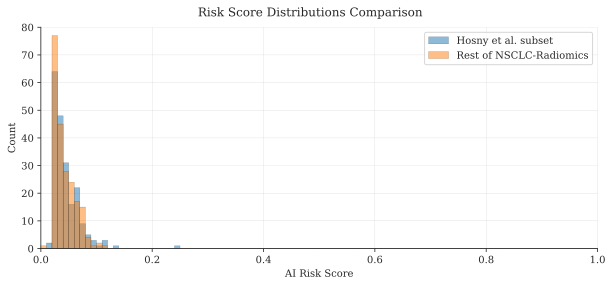

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

ax.hist(
    y_pred_replication,
    bins=np.linspace(0, 1, 101),
    alpha=0.5,
    edgecolor='black',
    linewidth=.25
    )

ax.hist(
    list(set(y_pred_extension) - set(y_pred_replication)),
    bins=np.linspace(0, 1, 101),
    alpha=0.5,
    edgecolor='black',
    linewidth=.25
    )

ax.set_xlim([0, 1.0])
ax.set_ylim([0, 80])

ax.grid(linewidth = .25)

ax.set_xlabel('AI Risk Score')
ax.set_ylabel('Count')

ax.legend(labels=['Hosny et al. subset', 'Rest of NSCLC-Radiomics'], loc='upper right')

fig.suptitle("Risk Score Distributions Comparison", size=12, y=0.95)

sns.despine()

And test for a difference in the distribution.

The null hypothesis is that the distribution of the two scores is the same. If the p-value we get from this test is below the threshold of significance, then we can reject the null hypothesis.

In [35]:
mwustat, pval = stats.mannwhitneyu(
    y_pred_replication,
    list(set(y_pred_extension) - set(y_pred_replication))
    )

print(mwustat)
print(pval)

22756.0
0.6247154374117979


---

Furthermore, we can test the prognostic and stratification power of the model on the whole dataset by computing the Area Under the Curve, fitting a Cox PH model, and plotting the Kaplan-Meier curves.

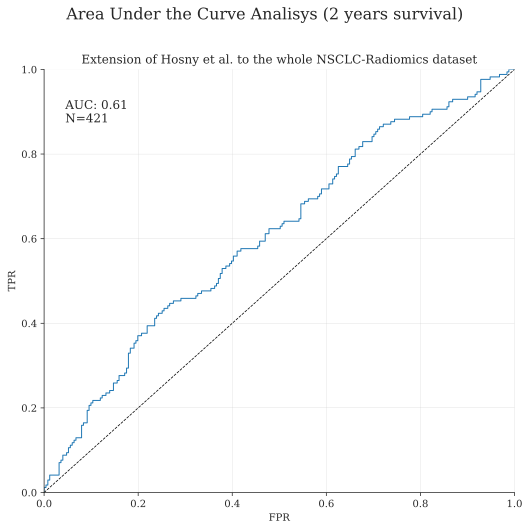

In [36]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

ax.plot(
    extension["fpr"],
    extension["tpr"],
    label = 'ROC AUC: %2.2f'%(extension["roc_auc"]),
    lw = 1,
    )

ax = style_axis_auc(ax)
ax.set_title('Extension of Hosny et al. to the whole NSCLC-Radiomics dataset')
ax.text(
    x=0.045, y=0.875,
    s='AUC: %2.2f\nN=%g'%(extension["roc_auc"], len(extension_df)),
    fontsize=12,
    )

fig.suptitle("Area Under the Curve Analisys (2 years survival)", size=16, y=0.95)
fig.tight_layout(pad=3.0)
sns.despine()

---

In [37]:
extension_df["group_extension"]="Low Risk"
extension_df["group_extension_cat"]=0

extension_df.loc[extension_df['CNN_logit0']>median_threshold, 'group_extension']="High Risk"
extension_df.loc[extension_df['CNN_logit0']>median_threshold, 'group_extension_cat']=1

In [38]:
results_df_extended = extension_df[["group_extension_cat", "Survival.time", "deadstatus.event"]]

cph_extended = CoxPHFitter()
cph_extended.fit(
    results_df_extended,
    duration_col='Survival.time',
    event_col='deadstatus.event'
    )

p_val_extended=cph_extended.summary["p"].values
cph_extended.print_summary()
#cph.plot()

<lifelines.CoxPHFitter: fitted with 421 total observations, 48 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 421
number of events observed = 373
   partial log-likelihood = -1966.71
         time fit was run = 2023-11-03 16:23:29 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
group_extension_cat   0.27       1.31       0.12             0.04             0.50                 1.04                 1.65

                      cmp to    z    p   -log2(p)
covariate                                        
group_extension_cat     0.00 2.32 0.02       5.61
---
Concordance = 0.54
Partial AIC = 3935.43
log-likelihood ratio test = 5.14 on 1 df
-log2(p) of ll-ratio test = 5.42

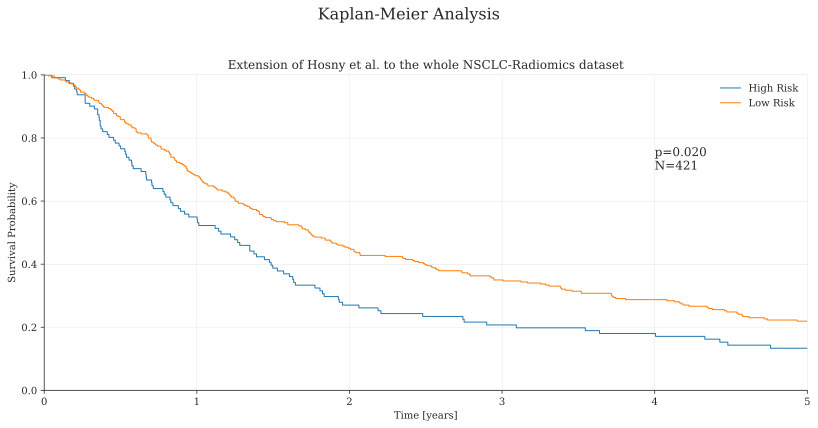

In [39]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6.5))

kmf = KaplanMeierFitter()

for name, grouped_df in extension_df.groupby('group_extension'):
    kmf.fit(
        grouped_df["Survival.time"],
        grouped_df["deadstatus.event"],
        label=name,
        alpha = 0.1)

    kmf.plot_survival_function(
        ax=ax,
        lw=1,
        ci_alpha=0.0,
        )

ax.set_title("Extension of Hosny et al. to the whole NSCLC-Radiomics dataset")
ax = style_axis_km(ax)

ax.text(
    x=365.25*4, y=0.7,
    s='p=%2.3f\nN=%g'%(
        p_val_extended,
        len(extension_df)
        ),
    fontsize=12,
    )

fig.suptitle("Kaplan-Meier Analysis", size=16, y=0.95)
fig.tight_layout(pad=3.0)
sns.despine()

We can conclude that, however reduced, the stratification and prognostic power of the model is still good enough to identify a subset of patients at much higher risk of death compared to the baseline.